# Face recognition

In [261]:
import gc
import itertools
import random
from glob import glob
import os
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm  # https://timm.fast.ai/
import torch
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from torch import nn
from torch.utils.data import DataLoader, Dataset, IterableDataset
from tqdm import tqdm

In [37]:
SEED = 42
np.random.seed(SEED)

### Get data

In [12]:
# !tar -xvf lfw_funneled_v2.tar.xz
# !mv lfw_funneled lfw_funneled_v2

In [232]:
!ls -la lfw_funneled_v2/Yoko_Ono/

total 48
drwxr-xr-x 1 baibak baibak    204 Jul 28 01:14 .
drwxr-xr-x 1 baibak baibak 154630 Jul 27 06:53 ..
-rw-r--r-- 1 baibak baibak   6064 Jul 27 06:52 Yoko_Ono_0001.jpg
-rw-r--r-- 1 baibak baibak   6307 Jul 27 06:52 Yoko_Ono_0002.jpg
-rw-r--r-- 1 baibak baibak   6903 Jul 27 06:52 Yoko_Ono_0003.jpg
-rw-r--r-- 1 baibak baibak   7320 Jul 27 06:52 Yoko_Ono_0004.jpg
-rw-r--r-- 1 baibak baibak   7372 Jul 27 06:52 Yoko_Ono_0005.jpg
-rw-r--r-- 1 baibak baibak   6750 Jul 27 06:52 Yoko_Ono_0006.jpg


In [15]:
DATA_DIR = 'lfw_funneled_v2'

In [16]:
data = []

for user in tqdm(glob('lfw_funneled_v2/*')):
    user_name = user.split('/')[1]
    if '.txt' in user_name:
        continue

    data.append([user_name, len(glob(user + '/*'))])

100%|██████████| 5749/5749 [00:00<00:00, 31745.08it/s]


In [17]:
df_users = pd.DataFrame(columns=['user_name', 'num_of_photos'], data=data)

print(df_users.shape)
df_users.head()

(5738, 2)


,user_name,num_of_photos
0,German_Khan,1
1,Stefano_Gabbana,1
2,Dragan_Covic,1
3,Jeff_Hornacek,1
4,Sureyya_Ayhan,1


In [18]:
df_users.num_of_photos.value_counts()[:10]

1     4059
2      782
3      287
4      189
5      110
6       56
7       40
8       32
9       25
11      16
Name: num_of_photos, dtype: int64

In [247]:
np.random.choice(os.listdir(path.join(DATA_DIR, "John_Stockton")), 2)[0]

'John_Stockton_0003.jpg'

In [255]:
people_multi_photos_data = {}
people_all_data = {}
total_photos = 0

for person_name in os.listdir(DATA_DIR):
    person_name_dir = os.path.join(DATA_DIR, person_name)

    if not os.path.isdir(person_name_dir):
        continue

    pic_files = []

    for picture in os.listdir(person_name_dir):
        person_name_pic = os.path.join(DATA_DIR, person_name, picture)

        if not os.path.isfile(person_name_pic):
            continue

        pic_files.append(torch.from_numpy(io.imread(person_name_pic)).permute(2, 0, 1) / 255.0)
        total_photos += 1

    if not pic_files:
        continue

    people_all_data[person_name] = pic_files

    if len(pic_files) > 1:
        people_multi_photos_data[person_name] = pic_files

people_all_names = list(people_all_data.keys())

print(f"Number of people with multiple pics: {len(people_multi_photos_data)}")
print(f"Total number of people: {len(people_all_data)}")

Number of people with multiple pics: 1679
Total number of people: 5738


In [402]:
class ModelDataset(IterableDataset):
    def __init__(self, people_multi_photos_data, people_all_data, size, *args, **kwargs):
        IterableDataset.__init__(self, *args, **kwargs)

        self.people_multi_photos_data = people_multi_photos_data
        self.people_all_data = people_all_data
        self.size = size

    def a_random_sample(self):
        anchor_person_name, anchor_pic_files = random.choice(list(self.people_multi_photos_data.items()))

        pic_file_positive_idx = pic_file_anchor_idx = random.randint(0, len(anchor_pic_files) - 1)

        while pic_file_anchor_idx == pic_file_positive_idx:
            pic_file_positive_idx = random.randint(0, len(anchor_pic_files) - 1)

        negative_person_name = anchor_person_name
        while negative_person_name == anchor_person_name:
            negative_person_name = random.choice(people_all_names)

        return [
            anchor_pic_files[pic_file_anchor_idx],
            anchor_pic_files[pic_file_positive_idx],
            random.choice(people_all_data[negative_person_name]),
        ]

    def __len__(self):
        # print(f"size {self.size}")
        return self.size

    def __getitem__(self, *args, **kwargs):
        return self.a_random_sample()

    def __iter__(self):
        for _ in range(self.size):
            yield self.a_random_sample()

In [291]:
keys_train, keys_valid = train_test_split(list(people_multi_photos_data.keys()), test_size=0.15, random_state=SEED)

keys_train = set(keys_train)
keys_valid = set(keys_valid)

In [293]:
people_multi_photos_train = {k: v for k, v in people_multi_photos_data.items() if k in keys_train}
people_multi_photos_valid = {k: v for k, v in people_multi_photos_data.items() if k in keys_valid}

In [382]:
train_set = ModelDataset(people_multi_photos_train, people_all_data, 1400)
valid_set = ModelDataset(people_multi_photos_valid, people_all_data, 250)

In [383]:
print(len(train_set), len(valid_set))

size 1400
size 250
1400 250


#### Prepare a dataset of triplets

In [35]:
data = []
mask = np.random.choice([False, True], len(df_users), p=[0.7, 0.3])

for (user_name, num_of_photos) in tqdm(df_users[mask].values):
    # Ignore anythign with only one photo -- we need at least two.
    if num_of_photos < 2:
        continue

    # get all combinations like "ancor - positive"
    combs = range(1, min(num_of_photos + 1, 5))
    
    for (ancor, pos) in itertools.combinations(combs, 2):
        curr = []
        
        # ancor and positive
        # Get random filenames from those that exist in teh directory
        user_sample = np.random.choice(os.listdir(path.join(DATA_DIR, user_name)), 2)

        path_anc = path.join(DATA_DIR, user_name, user_sample[0])
        path_pos = path.join(DATA_DIR, user_name, user_sample[1])

        curr.append(path_anc)
        curr.append(path_pos)

        # random negative
        neg = df_users.sample(1)
        while neg.user_name.values[0] == user_name:
            neg = df_users.sample(1)

        neg_user = neg.user_name.values[0]
        neg_sample = np.random.choice(os.listdir(path.join(DATA_DIR, neg_user)), 1)
        path_neg = path.join(DATA_DIR, neg_user, neg_sample[0])
        curr.append(path_neg)

        data.append(curr)



df_triplets = pd.DataFrame(columns=['ancor', 'positive', 'negative'], data=data)
print()
print(df_triplets.shape)
df_triplets.head()

100%|██████████| 1718/1718 [00:01<00:00, 1614.55it/s]



(1501, 3)


,ancor,positive,negative
0,lfw_funneled_v2/Mary-Kate_Olsen/Mary-Kate_Olse...,lfw_funneled_v2/Mary-Kate_Olsen/Mary-Kate_Olse...,lfw_funneled_v2/Mohammad_Aktar/Mohammad_Aktar_...
1,lfw_funneled_v2/Mary-Kate_Olsen/Mary-Kate_Olse...,lfw_funneled_v2/Mary-Kate_Olsen/Mary-Kate_Olse...,lfw_funneled_v2/Michael_Lopez-Alegria/Michael_...
2,lfw_funneled_v2/Mary-Kate_Olsen/Mary-Kate_Olse...,lfw_funneled_v2/Mary-Kate_Olsen/Mary-Kate_Olse...,lfw_funneled_v2/Tom_Brennan/Tom_Brennan_0001.jpg
3,lfw_funneled_v2/Mark_Richt/Mark_Richt_0001.jpg,lfw_funneled_v2/Mark_Richt/Mark_Richt_0003.jpg,lfw_funneled_v2/Dion_Glover/Dion_Glover_0001.jpg
4,lfw_funneled_v2/Mark_Richt/Mark_Richt_0002.jpg,lfw_funneled_v2/Mark_Richt/Mark_Richt_0001.jpg,lfw_funneled_v2/Oswald_Gruebel/Oswald_Gruebel_...


#### train/test split

In [38]:
# df_train, df_valid = train_test_split(df_triplets, test_size=0.15, random_state=SEED)

### Create APN Dataset 

In [39]:
# class APN(Dataset):
#     def __init__(self, df: pd.DataFrame):
#         self.df = df

#     def __len__(self):
#         return self.df.shape[0]

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]

#         ancor_img = io.imread(row.ancor)
#         pos_img = io.imread(row.positive)
#         neg_img = io.imread(row.negative)

#         ancor_img = torch.from_numpy(ancor_img).permute(2, 0, 1) / 255.0
#         pos_img = torch.from_numpy(pos_img).permute(2, 0, 1) / 255.0
#         neg_img = torch.from_numpy(neg_img).permute(2, 0, 1) / 255.0

#         return ancor_img, pos_img, neg_img

In [40]:
# train_set = APN(df_train)
# valid_set = APN(df_valid)

# print(len(train_set), len(valid_set))

1275 226


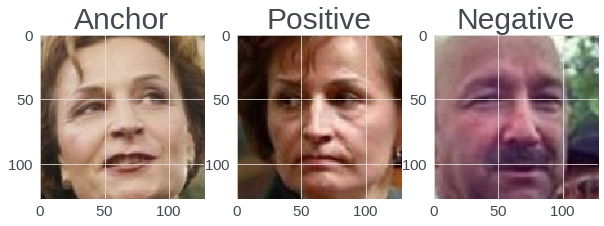

In [385]:
idx = 90
A, P, N = train_set[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap='gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap='gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap='gray');

### Load Dataset into Batches

In [391]:
BATCH_SIZE = 8

# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
# valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

print(f'No. of batches in trainloader: {len(train_loader)}')
print(f'No. of batches in validloader: {len(valid_loader)}')

size 1400
No. of batches in trainloader: 175
size 250
No. of batches in validloader: 32


In [392]:
for A, P, N in train_loader:
    break
    
print(f'One image batch shape : {A.shape}')

One image batch shape : torch.Size([8, 3, 128, 128])


### Create Model 

In [393]:
EMBEDDING_SIZE = 300
DEVICE = 'cuda'

In [394]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=EMBEDDING_SIZE):
        super(APN_Model, self).__init__()

        self.efficient_net = timm.create_model("efficientnet_b0", pretrained=False)
        # load pre-trained weights
        self.efficient_net.load_state_dict(torch.load("/var/svcscm/efficientnet_b0_ra-3dd342df.pth"))
        # adjust the output dimension (embeddings size)
        self.efficient_net.classifier = nn.Linear(
            in_features=self.efficient_net.classifier.in_features, out_features=emb_size
        )

    def forward(self, images):
        embeddings = self.efficient_net(images)

        return embeddings

In [395]:
gc.collect()
torch.cuda.empty_cache()

In [396]:
model = APN_Model()
# model.to(DEVICE);

### Create Train and Eval function

In [397]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = .0

    for ancor, pos, neg in tqdm(data_loader):
        # ancor, pos, neg = ancor.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)

        embs_ancor = model(ancor)
        embs_pos = model(pos)
        embs_neg = model(neg)

        loss = criterion(embs_ancor, embs_pos, embs_neg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

    return total_loss / len(data_loader)

In [398]:
def valid(model, data_loader, criterion):
    model.eval()
    total_loss = .0

    for ancor, pos, neg in tqdm(data_loader):
        # ancor, pos, neg = ancor.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)

        embs_ancor = model(ancor)
        embs_pos = model(pos)
        embs_neg = model(neg)

        loss = criterion(embs_ancor, embs_pos, embs_neg)
        total_loss += loss

    return total_loss / len(data_loader)

In [399]:
LR = 0.001

criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### Create Training Loop

In [400]:
EPOCHS = 15
MODEL_VERSION = "0.2.1"

In [401]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)

    gc.collect()
    torch.cuda.empty_cache()

    valid_loss = valid(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), f"best_model_{MODEL_VERSION}.pt")
        best_valid_loss = valid_loss
        print("###### Saved weight success")

    print(f"### Epochs: {i + 1} / train_loss: {train_loss} / valid_loss: {valid_loss}")

size 1400


100%|██████████| 175/175 [01:48<00:00,  1.62it/s]


size 1400


size 250


100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


size 250


###### Saved weight success
### Epochs: 1 / train_loss: 0.9998372793197632 / valid_loss: 1.0048213005065918
size 1400


100%|██████████| 175/175 [01:52<00:00,  1.56it/s]


size 1400


size 250


100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


size 250


###### Saved weight success
### Epochs: 2 / train_loss: 0.7137763500213623 / valid_loss: 0.6601293087005615
size 1400


100%|██████████| 175/175 [01:51<00:00,  1.56it/s]


size 1400
size 250


100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


size 250


###### Saved weight success
### Epochs: 3 / train_loss: 0.5837410092353821 / valid_loss: 0.5979017019271851
size 1400


100%|██████████| 175/175 [01:53<00:00,  1.54it/s]


size 1400


size 250


100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


size 250


###### Saved weight success
### Epochs: 4 / train_loss: 0.4516010880470276 / valid_loss: 0.4145887494087219
size 1400


100%|██████████| 175/175 [01:53<00:00,  1.54it/s]


size 1400


size 250


100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


size 250
### Epochs: 5 / train_loss: 0.43900570273399353 / valid_loss: 0.4732555150985718
size 1400


100%|██████████| 175/175 [01:57<00:00,  1.49it/s]


size 1400


size 250


100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


size 250


### Epochs: 6 / train_loss: 0.41643258929252625 / valid_loss: 0.5593613386154175
size 1400


100%|██████████| 175/175 [01:51<00:00,  1.56it/s]


size 1400


size 250


100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


size 250


### Epochs: 7 / train_loss: 0.4083382189273834 / valid_loss: 0.4796719551086426
size 1400


100%|██████████| 175/175 [01:53<00:00,  1.54it/s]


size 1400
size 250


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


size 250


### Epochs: 8 / train_loss: 0.36854788661003113 / valid_loss: 0.45874932408332825
size 1400


100%|██████████| 175/175 [01:49<00:00,  1.59it/s]


size 1400


size 250


100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


size 250
### Epochs: 9 / train_loss: 0.38015079498291016 / valid_loss: 0.47720828652381897
size 1400


100%|██████████| 175/175 [01:50<00:00,  1.58it/s]


size 1400


size 250


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


size 250


###### Saved weight success
### Epochs: 10 / train_loss: 0.3709036111831665 / valid_loss: 0.36104443669319153
size 1400


100%|██████████| 175/175 [01:46<00:00,  1.65it/s]


size 1400
size 250


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


size 250
### Epochs: 11 / train_loss: 0.32443657517433167 / valid_loss: 0.38833773136138916
size 1400


100%|██████████| 175/175 [01:45<00:00,  1.65it/s]


size 1400


size 250


100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


size 250


### Epochs: 12 / train_loss: 0.33112919330596924 / valid_loss: 0.4217996895313263
size 1400


100%|██████████| 175/175 [01:42<00:00,  1.71it/s]


size 1400


size 250


100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


size 250
### Epochs: 13 / train_loss: 0.27420592308044434 / valid_loss: 0.3657801151275635
size 1400


100%|██████████| 175/175 [01:45<00:00,  1.66it/s]


size 1400


size 250


100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


size 250
### Epochs: 14 / train_loss: 0.3060097098350525 / valid_loss: 0.36466658115386963
size 1400


100%|██████████| 175/175 [01:44<00:00,  1.67it/s]


size 1400


size 250


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


size 250


###### Saved weight success
### Epochs: 15 / train_loss: 0.28588220477104187 / valid_loss: 0.330897718667984


In [105]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)

    gc.collect()
    torch.cuda.empty_cache()

    valid_loss = valid(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), f"best_model_{MODEL_VERSION}.pt")
        best_valid_loss = valid_loss
        print("###### Saved weight success")

    print(f"### Epochs: {i + 1} / train_loss: {train_loss} / valid_loss: {valid_loss}")

100%|██████████| 160/160 [01:40<00:00,  1.59it/s]


100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


###### Saved weight success
### Epochs: 1 / train_loss: 0.7897740006446838 / valid_loss: 1.4466948509216309


100%|██████████| 160/160 [01:39<00:00,  1.61it/s]


100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


###### Saved weight success
### Epochs: 2 / train_loss: 0.6057320833206177 / valid_loss: 0.5456507205963135


100%|██████████| 160/160 [01:41<00:00,  1.57it/s]


100%|██████████| 29/29 [00:06<00:00,  4.72it/s]


### Epochs: 3 / train_loss: 0.43216538429260254 / valid_loss: 0.5961921811103821


100%|██████████| 160/160 [01:39<00:00,  1.61it/s]


100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


###### Saved weight success
### Epochs: 4 / train_loss: 0.3731669783592224 / valid_loss: 0.42781898379325867


100%|██████████| 160/160 [01:38<00:00,  1.62it/s]


100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


###### Saved weight success
### Epochs: 5 / train_loss: 0.30439871549606323 / valid_loss: 0.3766137361526489


100%|██████████| 160/160 [01:41<00:00,  1.58it/s]


100%|██████████| 29/29 [00:06<00:00,  4.52it/s]


###### Saved weight success
### Epochs: 6 / train_loss: 0.22974547743797302 / valid_loss: 0.3283485472202301


100%|██████████| 160/160 [01:39<00:00,  1.61it/s]


100%|██████████| 29/29 [00:06<00:00,  4.65it/s]


### Epochs: 7 / train_loss: 0.16633310914039612 / valid_loss: 0.41090118885040283


100%|██████████| 160/160 [01:38<00:00,  1.62it/s]


100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


### Epochs: 8 / train_loss: 0.2589927911758423 / valid_loss: 0.44579875469207764


100%|██████████| 160/160 [01:37<00:00,  1.64it/s]


100%|██████████| 29/29 [00:06<00:00,  4.53it/s]


###### Saved weight success
### Epochs: 9 / train_loss: 0.22210702300071716 / valid_loss: 0.29415154457092285


100%|██████████| 160/160 [01:38<00:00,  1.62it/s]


100%|██████████| 29/29 [00:06<00:00,  4.57it/s]


### Epochs: 10 / train_loss: 0.12970532476902008 / valid_loss: 0.38515815138816833


In [403]:
model.load_state_dict(torch.load(f"best_model_{MODEL_VERSION}.pt"))

<All keys matched successfully>

### Evaluation

In [404]:
def img_2_vec(model: APN_Model, img_path: str) -> np.ndarray:
    """Gets the path to an image of some face and returns a vector representation for this face."""
    model.eval()

    with torch.no_grad():
        img = io.imread(img_path)
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
        vec = model(img.unsqueeze(0))

    return vec.squeeze().numpy()

In [405]:
model.eval()

with torch.no_grad():
    for i, (ancor, pos, neg) in enumerate(df_valid.values[:20]):
        embs_ancor = img_2_vec(model, ancor)
        embs_pos = img_2_vec(model, pos)
        embs_neg = img_2_vec(model, neg)

        print(
            i,
            f"Positive: {cosine_similarity([embs_ancor], [embs_pos])[0]}",
            f"Negative: {cosine_similarity([embs_ancor], [embs_neg])[0]}",
        )

0 Positive: [0.9898374] Negative: [0.9256551]
1 Positive: [0.9999999] Negative: [0.9381279]
2 Positive: [0.97845674] Negative: [0.6822567]
3 Positive: [0.98161983] Negative: [0.9719275]


4 Positive: [0.9999999] Negative: [0.7853958]
5 Positive: [0.9974397] Negative: [0.7819063]
6 Positive: [0.99999976] Negative: [0.97560483]
7 Positive: [0.8347657] Negative: [0.7097355]


8 Positive: [1.] Negative: [0.76115143]
9 Positive: [1.0000002] Negative: [0.78921497]
10 Positive: [0.9999998] Negative: [0.86077356]
11 Positive: [0.9910892] Negative: [0.6652256]


12 Positive: [0.9970616] Negative: [0.8801017]
13 Positive: [1.0000001] Negative: [0.66736484]
14 Positive: [1.] Negative: [0.93351525]
15 Positive: [0.9868854] Negative: [0.91598535]


16 Positive: [1.] Negative: [0.87278605]
17 Positive: [0.89359397] Negative: [0.9800707]
18 Positive: [0.9925591] Negative: [0.87094545]
19 Positive: [0.89689445] Negative: [0.8617426]


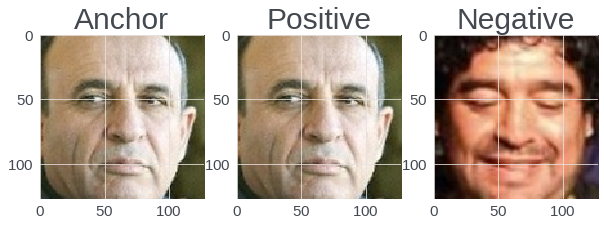

In [406]:
# interesting examples from valid_set: 0, 17

idx = 9
A, P, N = df_valid.iloc[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title("Anchor")
ax1.imshow(io.imread(A), cmap="gray")

ax2.set_title("Positive")
ax2.imshow(io.imread(P), cmap="gray")

ax3.set_title("Negative")
ax3.imshow(io.imread(N), cmap="gray")

In [242]:
model.eval()

with torch.no_grad():
    for i, (ancor, pos, neg) in enumerate(df_valid.values[:20]):
        embs_ancor = img_2_vec(model, ancor)
        embs_pos = img_2_vec(model, pos)
        embs_neg = img_2_vec(model, neg)

        print(
            i,
            f"Positive: {cosine_similarity([embs_ancor], [embs_pos])[0]}",
            f"Negative: {cosine_similarity([embs_ancor], [embs_neg])[0]}",
        )

0 Positive: [0.9894561] Negative: [0.9458834]
1 Positive: [1.0000001] Negative: [0.9156742]
2 Positive: [0.9295019] Negative: [0.4590755]
3 Positive: [0.5847862] Negative: [0.7813233]


4 Positive: [1.] Negative: [0.445685]
5 Positive: [0.8228749] Negative: [0.5311701]
6 Positive: [0.99999994] Negative: [0.6212117]
7 Positive: [0.5587728] Negative: [0.45972446]


8 Positive: [1.] Negative: [-0.04280525]
9 Positive: [1.] Negative: [0.60725546]
10 Positive: [1.] Negative: [0.7884289]
11 Positive: [0.91714936] Negative: [0.558753]


12 Positive: [0.96683306] Negative: [0.6053434]
13 Positive: [0.99999976] Negative: [0.8627301]
14 Positive: [1.0000002] Negative: [0.31622687]
15 Positive: [0.9766573] Negative: [0.23812035]


16 Positive: [1.0000002] Negative: [0.629295]
17 Positive: [0.6428971] Negative: [0.19168963]
18 Positive: [0.961223] Negative: [0.89908576]
19 Positive: [0.79413277] Negative: [0.7888726]


tensor([[[0.3765, 0.3725, 0.3686,  ..., 0.3882, 0.3451, 0.3020],
         [0.3686, 0.3647, 0.3608,  ..., 0.4353, 0.3686, 0.2980],
         [0.3608, 0.3608, 0.3569,  ..., 0.4314, 0.3725, 0.3059],
         ...,
         [0.8784, 0.8588, 0.8314,  ..., 0.7451, 0.7843, 0.8157],
         [0.8627, 0.8471, 0.8196,  ..., 0.7882, 0.8275, 0.8392],
         [0.8549, 0.8471, 0.8196,  ..., 0.8392, 0.8471, 0.8275]],

        [[0.3529, 0.3490, 0.3451,  ..., 0.3765, 0.3216, 0.2784],
         [0.3451, 0.3412, 0.3373,  ..., 0.4235, 0.3451, 0.2745],
         [0.3373, 0.3373, 0.3333,  ..., 0.4196, 0.3569, 0.2902],
         ...,
         [0.7059, 0.6941, 0.6667,  ..., 0.7451, 0.7882, 0.8196],
         [0.6824, 0.6745, 0.6471,  ..., 0.7882, 0.8314, 0.8431],
         [0.6745, 0.6667, 0.6392,  ..., 0.8392, 0.8510, 0.8314]],

        [[0.2667, 0.2627, 0.2588,  ..., 0.3176, 0.2745, 0.2314],
         [0.2588, 0.2549, 0.2510,  ..., 0.3647, 0.2980, 0.2275],
         [0.2510, 0.2510, 0.2471,  ..., 0.3608, 0.3098, 0.

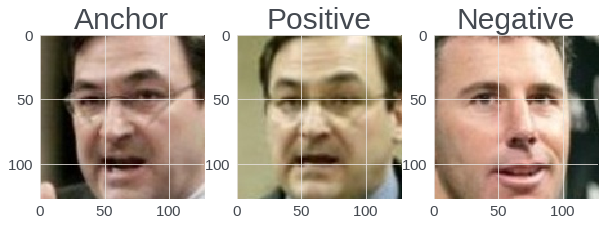

In [349]:
# interesting examples from valid_set: 0, 17

idx = 0
A, P, N = valid_set[idx]

# print(A.numpy().transpose((1, 2, 0)))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title("Anchor")
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap="gray")

ax2.set_title("Positive")
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap="gray")

ax3.set_title("Negative")
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap="gray")